In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import math
import re
import os

#stats and bioinformatics
from scipy import stats
from scipy import spatial

from statsmodels.stats.multitest import multipletests

import skbio as skbio
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim
from skbio.stats.distance import permanova
import networkx as nx

#visualizing results
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

## Paths and mapping

### import data

#### animal meta data

In [2]:
#import path for directory containing files from CoreBiome and corresponding sample/animal key
path_animal = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/samples_all.xlsx'

data_animal_meta = pd.read_excel(path_animal)
data_animal_meta = pd.DataFrame(data = data_animal_meta)
data_animal_meta['animal_code'] = [str(x) for x in data_animal_meta['animal_code']]
#just keep 112 timepoint
print(data_animal_meta.shape)
data_animal_meta = data_animal_meta[data_animal_meta['feces_tp'] == 112]
print(data_animal_meta.shape)
data_animal_meta.head()

(205, 48)
(41, 48)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency
0,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,145.S,145.S,NaN,CD40,4,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8,29.8,29.5,29.3,NaN,30.0,0.000000,-1.677852,NaN,0.671141,24.840,0.083,15.0,28.6,3.154,3.4
1,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,146.S,146.S,NaN,CD40,4,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.6,28.6,28.5,NaN,28.7,-0.694444,-1.041667,NaN,-0.347222,34.051,0.114,14.0,14.2,3.879,26.3
2,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,147.S,147.S,NaN,CD40,4,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2,28.3,28.4,28.5,NaN,28.5,0.354610,1.063830,NaN,1.063830,34.507,0.115,13.0,16.0,4.325,41.4
3,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,148.S,148.S,"tail nick, scruffy",CD41,7,m,112,f,3,NaN,2,NaN,20.70,21.31,21.005000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.4,30.3,27.4,27.9,NaN,29.1,-6.481481,-13.888889,NaN,-10.185185,24.956,0.083,14.0,45.2,5.211,11.0
4,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,149.S,149.S,"chin scratches, scruffy",CD41,7,m,112,f,3,NaN,2,19.18,20.65,17.66,19.163333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.7,28.7,26.5,26.9,NaN,28.4,-6.514658,-12.377850,NaN,-7.491857,20.605,0.069,10.0,15.9,3.130,75.9


In [3]:
data_animal_meta.groupby(['feces_tp', 'Group', ]).count()

Protocol  Round_summary  Round_main  Round_addl  file_name  Animal_#  animal_code  Notes  Cage_#  Sex  feces_fs  Acute_OFB  Sac_TP  Treatment  PSI_1  PSI_2  PSI_3  PSI_ave  ms_1  ms_2  ms_3  ms_ave  imp_1  imp_2  imp_3  imp_ave  LORR_1  LORR_2  LORR_3  LORR_ave  wt_1  wt_2  wt_3  wt_24  wt_48  wt_72  wt_overnight  wt_24.1  wt_48.1  wt_72.1  Distance  Mean speed  Center : entries  Center : time  Center : distance  Center : latency
feces_tp Group                                                                                                                                                                                                                                                                                                                                                                                                                                                   
112      4            12             12          12           0         12        12           12      1      12   12        12         12       0         12      0      0      0        0     0     0     0       0      0      0      0        0       0       0       0         0    12    12    12      9      0      9            12        9        0        9         9           9                 9              9                  9                 9
         5             9              9           9           0          9         9            9      5       9    9         9          9       0          9      9      9      9        9     0     0     0       0      0      0      0        0       0       0       0         0     9     9     9      5      0      5             9        5        0        5         5           5                 5              5                  5                 5
         7             8              8           8           0          8         8            8      6       8    8         8          8       0          8      7      8      8        8     0     0     0       0      0      0      0        0       0       0       0         0     8     8     8      8      0      8             8        8        0        8         8           8                 8              8                  8                 8
         10            6              6           6           0          6         6            6      0       6    6         6          6       0          6      0      0      0        0     0     0     0       0      0      0      0        0       0       0       0         0     6     6     6      0      0      0             6        0        0        0         0           0                 0              0                  0                 0
         11            6              6           6           0          6         6            6      0       6    6         6          6       0          6      6      6      6        6     0     0     0       0      0      0      0        0       0       0       0         0     6     6     6      0      0      0             6        0        0        0         0           0                 0              0                  0                 0

In [4]:
group_map = {4:'Sham', 5:'Blast', 7:'Blast_VNS', 10:'Sham_EtOHwd', 11:'Blast_EtOHwd'}
data_animal_meta['Group'] = data_animal_meta['Group'].map(group_map)
data_animal_meta.head()

,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency
0,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,145.S,145.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8,29.8,29.5,29.3,NaN,30.0,0.000000,-1.677852,NaN,0.671141,24.840,0.083,15.0,28.6,3.154,3.4
1,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,146.S,146.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.6,28.6,28.5,NaN,28.7,-0.694444,-1.041667,NaN,-0.347222,34.051,0.114,14.0,14.2,3.879,26.3
2,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,147.S,147.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2,28.3,28.4,28.5,NaN,28.5,0.354610,1.063830,NaN,1.063830,34.507,0.115,13.0,16.0,4.325,41.4
3,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,148.S,148.S,"tail nick, scruffy",CD41,Blast_VNS,m,112,f,3,NaN,2,NaN,20.70,21.31,21.005000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.4,30.3,27.4,27.9,NaN,29.1,-6.481481,-13.888889,NaN,-10.185185,24.956,0.083,14.0,45.2,5.211,11.0
4,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,149.S,149.S,"chin scratches, scruffy",CD41,Blast_VNS,m,112,f,3,NaN,2,19.18,20.65,17.66,19.163333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.7,28.7,26.5,26.9,NaN,28.4,-6.514658,-12.377850,NaN,-7.491857,20.605,0.069,10.0,15.9,3.130,75.9


#### path mapping

In [5]:
#import path for directory containing files from CoreBiome and corresponding sample/animal key
path_mapping = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/MB_files_meta.xlsx'

data_path_mapping = pd.read_excel(path_mapping)
data_path_mapping = pd.DataFrame(data = data_path_mapping)
print(data_path_mapping.shape)
data_path_mapping

(15, 4)


,type,path_outer,path_inner,path_filename
0,phylum,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-phylum-short-relative.tsv
1,class,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-class-short-relative.tsv
2,order,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-order-short-relative.tsv
3,family,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-family-short-relative.tsv
4,genus,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-genus-short-relative.tsv
5,species,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-species-short-relative.tsv
6,strain,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-strain-short-relative.tsv
7,taxa,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables,taxatable-filtered-relative.tsv
8,otu,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables,otutable-filtered-relative.tsv
9,enzyme,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/functional-tables,kotable-enzyme-filtered-relative.tsv


#### file path mapping function

In [6]:
def make_path(ship_name, mapping_type):
    #creates path 
    #ship_index = index of ship_file_names to use (referres to shipping round)
    #mapping_index = type to use for data_path_mapping (referrers to data type)
    data_mapping = data_path_mapping[data_path_mapping['type'] == mapping_type]
    
    path = str(data_mapping['path_outer'].unique()[0] + 
           '/' + ship_name + 
           '/' + data_mapping['path_inner'].unique()[0] + 
           '/' + data_mapping['path_filename'].unique()[0])
    
    return path


In [7]:
#get unique file names (each is a shippment of samples)
ship_file_names = data_animal_meta['file_name'].dropna().unique()
ship_file_names

array(['ship1_VNS4m_24h_72h', 'ship2_VNS72h_norBNI72h_4m',
       'ship3_mf1d_CLAMS272h_etoh'], dtype=object)

## Alpha and beta diversity

### alpha diversity

#### compile animal meta and alpha

In [8]:
#use file name to create path of files
data_alpha = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'alpha')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int)
    data_int.columns = ['animal_code', 'observed', 'chao1', 'shannon']
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_alpha.shape[0] == 0:
        data_alpha = data_int
    else:
        data_alpha = pd.concat([data_alpha, data_int])
    
    print(data_alpha.shape)

data_alpha['animal_code'] = [str(x) for x in data_alpha['animal_code']]
print(data_alpha.shape)
data_alpha.head()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/alphadiversity/alphadiversity.txt
(35, 5)
(35, 5)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/alphadiversity/alphadiversity.txt
(57, 5)
(92, 5)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/alphadiversity/alphadiversity.txt
(49, 5)
(141, 5)
(141, 5)


,animal_code,observed,chao1,shannon,file_name
0,895.S,112.0,162.214286,3.383946,ship1_VNS4m_24h_72h
1,896.S,125.0,158.000000,3.587183,ship1_VNS4m_24h_72h
2,897.S,120.0,147.352941,3.758469,ship1_VNS4m_24h_72h
3,898.S,101.0,148.571429,2.147103,ship1_VNS4m_24h_72h
4,899.S,137.0,182.555556,3.482640,ship1_VNS4m_24h_72h


In [9]:
#combine with meta data
data_final = data_animal_meta.merge(data_alpha, 
                                          on=['animal_code', 'file_name'])

print(data_final.shape)
data_final.head()

(41, 51)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,observed,chao1,shannon
0,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,145.S,145.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8,29.8,29.5,29.3,NaN,30.0,0.000000,-1.677852,NaN,0.671141,24.840,0.083,15.0,28.6,3.154,3.4,152.0,201.500000,3.918775
1,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,146.S,146.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.6,28.6,28.5,NaN,28.7,-0.694444,-1.041667,NaN,-0.347222,34.051,0.114,14.0,14.2,3.879,26.3,181.0,227.406250,3.820705
2,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,147.S,147.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2,28.3,28.4,28.5,NaN,28.5,0.354610,1.063830,NaN,1.063830,34.507,0.115,13.0,16.0,4.325,41.4,160.0,205.000000,3.930043
3,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,148.S,148.S,"tail nick, scruffy",CD41,Blast_VNS,m,112,f,3,NaN,2,NaN,20.70,21.31,21.005000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.4,30.3,27.4,27.9,NaN,29.1,-6.481481,-13.888889,NaN,-10.185185,24.956,0.083,14.0,45.2,5.211,11.0,144.0,214.833333,3.487806
4,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,149.S,149.S,"chin scratches, scruffy",CD41,Blast_VNS,m,112,f,3,NaN,2,19.18,20.65,17.66,19.163333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.7,28.7,26.5,26.9,NaN,28.4,-6.514658,-12.377850,NaN,-7.491857,20.605,0.069,10.0,15.9,3.130,75.9,172.0,225.000000,3.828012


(14, 51)
observed


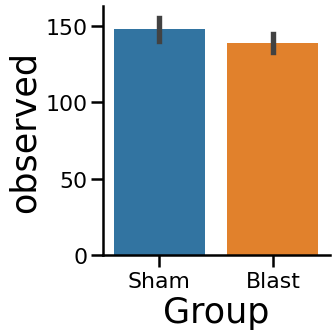



KruskalResult(statistic=1.9730088495575158, pvalue=0.16012885142717398)


shannon


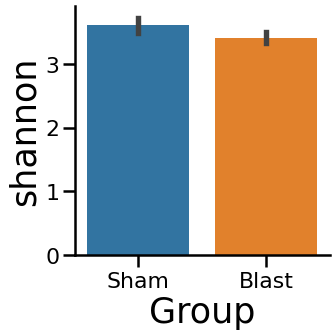



KruskalResult(statistic=1.0, pvalue=0.31731050786291115)


chao1


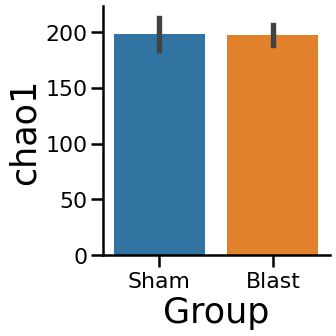



KruskalResult(statistic=0.004444444444445139, pvalue=0.9468470713992656)




In [11]:
group_exclude = ['Sham_EtOHwd', 'Blast_EtOHwd']
group_keep = ['Sham', 'Blast']
data_final_int = data_final[data_final['Group'].isin(group_keep)]
data_final_int = data_final_int[data_final_int['Round_summary']=='VNS']
print(data_final_int.shape)
#viz abundance params and compute significance
viz_params = ['observed', 'shannon', 'chao1']

for param in viz_params:
    try:
        print(param)

        g = sns.catplot(x='Group', y=param, data=data_final_int, kind='bar', height=5, aspect=1, ci=68,
                       order=['Sham', 'Blast'])
        plt.show()
        print('\n')
        
        x = data_final_int[data_final_int['Group'] == 'Sham'][param]
        y = data_final_int[data_final_int['Group'] == 'Blast'][param]
        z = data_final_int[data_final_int['Group'] == 'Blast_VNS'][param]
        print(stats.kruskal(x, y))
        print('\n')
        
    except:
        pass

In [ ]:
data_final_int

### beta diversity

#### compile animal meta and filtered otu table 

In [12]:
#use file name to create path of files
data_otu = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'otu')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int).set_index('@otu').T.reset_index()
    
    data_int.rename(columns={"index": 'animal_code'}, inplace=True)
    data_int['animal_code'] = [str(x) for x in data_int['animal_code']]
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_otu.shape[0] == 0:
        data_otu = data_int
    else:
        data_otu = pd.concat([data_otu, data_int])
    
    print(data_otu.shape)

#data_otu.replace({np.nan: 0}, inplace=True)    
print(data_otu.shape)
data_otu.tail()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/filtered-tables/otutable-filtered-relative.tsv
(35, 364)
(35, 364)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/filtered-tables/otutable-filtered-relative.tsv
(58, 371)
(93, 400)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/filtered-tables/otutable-filtered-relative.tsv
(49, 413)
(142, 464)
(142, 464)


,animal_code,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_001406695.1,GCF_001406715.1,GCF_001435325.1,GCF_001434435.1,GCF_001486665.1,GCF_001436695.1,GCF_001436575.1,GCF_001436315.1,GCF_001461035.1,GCF_001454945.1,GCF_001487165.1,GCF_001486905.1,GCF_001535605.1,GCF_001517625.2,GCF_001535615.1,GCF_001688765.2,GCF_001688705.2,GCF_001578565.1,GCF_001546525.1,GCF_001688665.2,GCF_001578575.1,GCF_001641065.1,GCF_001688625.2,GCF_001688645.2,GCF_001688725.2,GCF

In [13]:
#combine with meta data
data_otu_final = data_animal_meta.merge(data_otu, 
                                          on=['animal_code', 'file_name'])

print(data_otu_final.shape)
data_otu_final.head()

(41, 510)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_0014066

In [14]:
group_exclude = ['Sham_EtOHwd', 'Blast_EtOHwd']
group_keep = ['Sham', 'Blast']
data_all = data_otu_final[data_otu_final['Group'].isin(group_keep)]
data_all = data_all[data_all['Round_summary']=='VNS']

data_all.shape

(14, 510)

In [23]:
#data_all.replace({np.nan:0}, inplace=True)
data_all.dropna(axis=1, inplace=True)
print(data_all.columns.values[16:28])
otus = data_all.columns.values[28:]
#otus = data_all.columns.values[17:]


['wt_24' 'wt_72' 'wt_overnight' 'wt_24.1' 'wt_72.1' 'Distance'
 'Mean speed' 'Center : entries' 'Center : time' 'Center : distance'
 'Center : latency' 'GCF_001945605.1']


### compute beta

In [24]:
data_touse = data_all

ids = data_touse['animal_code'].values
#compute beta diversity dissimilary 
bc_dm = beta_diversity("braycurtis", data_touse[otus].to_numpy(), ids)

print(bc_dm[0])

[0.         0.30585272 0.28190459 0.36871554 0.19983074 0.18149192
 0.33538555 0.31490738 0.12759503 0.49740359 0.19065149 0.2521061
 0.25669249 0.30143385]


In [25]:
from skbio.stats.ordination import pcoa

pcoa_results = pcoa(bc_dm)
pc_df = skbio.stats.ordination.pcoa(bc_dm).samples
pc_df['animal_code'] = pc_df.index
data_beta_final = data_touse.merge(pc_df, on='animal_code')
data_beta_final.head()

,Protocol,Round_summary,Round_main,file_name,Animal_#,animal_code,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Treatment,wt_1,wt_2,wt_3,wt_24,wt_72,wt_overnight,wt_24.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_001406695.1,GCF_001406715.1,GCF_001435325.1,GCF_001434435.1,GCF_001486665.1,GCF_001436695.1,GCF_001436575.1,GCF_001436315.1,GCF_001461035.1,GCF_00145

In [26]:
#https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

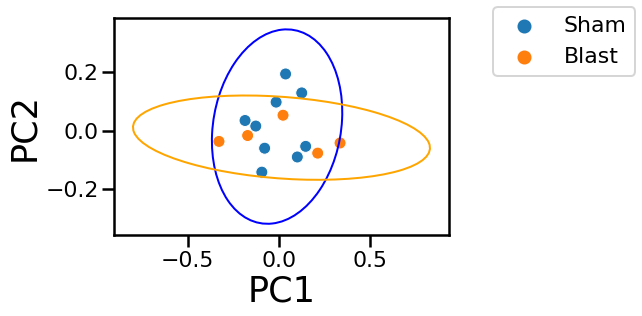

In [27]:
ax = sns.scatterplot(data=data_beta_final, x="PC1", y="PC2", hue='Group', )
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)

data_beta_final_s = data_beta_final[data_beta_final['Group']=='Sham']
confidence_ellipse(x=data_beta_final_s["PC1"], y=data_beta_final_s["PC2"], ax=ax, edgecolor='blue')

data_beta_final_b = data_beta_final[data_beta_final['Group']=='Blast']
confidence_ellipse(x=data_beta_final_b["PC1"], y=data_beta_final_b["PC2"], ax=ax, edgecolor='orange')

#data_beta_final_se = data_beta_final[data_beta_final['Group']=='Sham_EtOHwd']
#confidence_ellipse(x=data_beta_final_se["PC1"], y=data_beta_final_se["PC2"], ax=ax, edgecolor='orange')

#data_beta_final_be = data_beta_final[data_beta_final['Group']=='Blast_EtOHwd']
#confidence_ellipse(x=data_beta_final_be["PC1"], y=data_beta_final_be["PC2"], ax=ax, edgecolor='yellow')

plt.show()


In [28]:
sample_md = data_touse[['animal_code', 'Group']].set_index(['animal_code'])

#determine if sig
anosim_stat = anosim(bc_dm, sample_md, column='Group', permutations=5000)
print(anosim_stat, '\n')
permanova_stat = permanova(bc_dm, sample_md, column='Group', permutations=5000)
print(permanova_stat)

method name                  ANOSIM
test statistic name               R
sample size                      14
number of groups                  2
test statistic            0.0772947
p-value                    0.237552
number of permutations         5000
Name: ANOSIM results, dtype: object 

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      14
number of groups                  2
test statistic             0.364728
p-value                    0.776845
number of permutations         5000
Name: PERMANOVA results, dtype: object


## Taxa level analysis and viz

#### phylum

In [30]:
#use file name to create path of files
data_phylum = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'phylum')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int).set_index('@tax_phylum_level').T.reset_index()
    
    data_int.rename(columns={"index": 'animal_code'}, inplace=True)
    data_int['animal_code'] = [str(x) for x in data_int['animal_code']]
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_phylum.shape[0] == 0:
        data_phylum = data_int
    else:
        data_phylum = pd.concat([data_phylum, data_int])
    
    print(data_phylum.shape)

data_phylum.replace({np.nan: 0}, inplace=True)    
print(data_phylum.shape)
data_phylum.tail()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/filtered-tables/taxatables-by-level/taxatable-phylum-short-relative.tsv
(35, 9)
(35, 9)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/filtered-tables/taxatables-by-level/taxatable-phylum-short-relative.tsv
(58, 8)
(93, 9)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/filtered-tables/taxatables-by-level/taxatable-phylum-short-relative.tsv
(49, 8)
(142, 9)
(142, 9)


,animal_code,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia,file_name
44,874,0.000352,0.081537,0.712592,0.0,0.000165,0.001344,0.204011,ship3_mf1d_CLAMS272h_etoh
45,875,0.000390,0.006371,0.926102,0.0,0.000078,0.000293,0.066765,ship3_mf1d_CLAMS272h_etoh
46,997,0.127212,0.329998,0.405278,0.0,0.000871,0.010513,0.126128,ship3_mf1d_CLAMS272h_etoh
47,998,0.087672,0.139443,0.407054,0.0,0.000683,0.002814,0.362334,ship3_mf1d_CLAMS272h_etoh
48,999,0.028975,0.041315,0.558063,0.0,0.000369,0.002810,0.368468,ship3_mf1d_CLAMS272h_etoh


In [31]:
#combine with meta data
data_phylum_final = data_animal_meta.merge(data_phylum, 
                                          on=['animal_code', 'file_name'])

print(data_phylum_final.shape)
data_phylum_final.head()

(41, 55)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia
0,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,145.S,145.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8,29.8,29.5,29.3,NaN,30.0,0.000000,-1.677852,NaN,0.671141,24.840,0.083,15.0,28.6,3.154,3.4,0.137660,0.211756,0.619606,0.0,0.000355,0.005923,0.024700
1,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,146.S,146.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.6,28.6,28.5,NaN,28.7,-0.694444,-1.041667,NaN,-0.347222,34.051,0.114,14.0,14.2,3.879,26.3,0.026487,0.341850,0.611936,0.0,0.001303,0.002823,0.015601
2,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,147.S,147.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2,28.3,28.4,28.5,NaN,28.5,0.354610,1.063830,NaN,1.063830,34.507,0.115,13.0,16.0,4.325,41.4,0.109193,0.373448,0.411462,0.0,0.000844,0.003550,0.101503
3,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,148.S,148.S,"tail nick, scruffy",CD41,Blast_VNS,m,112,f,3,NaN,2,NaN,20.70,21.31,21.005000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.4,30.3,27.4,27.9,NaN,29.1,-6.481481,-13.888889,NaN,-10.185185,24.956,0.083,14.0,45.2,5.211,11.0,0.109413,0.343142,0.507327,0.0,0.000370,0.003835,0.035913
4,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,149.S,149.S,"chin scratches, scruffy",CD41,Blast_VNS,m,112,f,3,NaN,2,19.18,20.65,17.66,19.163333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.7,28.7,26.5,26.9,NaN,28.4,-6.514658,-12.377850,NaN,-7.491857,20.605,0.069,10.0,15.9,3.130,75.9,0.066784,0.399436,0.474790,0.0,0.000730,0.003194,0.055065


In [32]:
#calculate ratios etc.
data_phylum_final['fb_ratio'] = data_phylum_final['p__Firmicutes'] / data_phylum_final['p__Bacteroidetes']
data_phylum_final['va_sum'] = data_phylum_final['p__Verrucomicrobia'] + data_phylum_final['p__Actinobacteria']

In [37]:
data_phylum = data_phylum_final[data_phylum_final['Round_summary'] == 'VNS']
data_phylum = data_phylum[data_phylum['Group'] != 'Blast_VNS']
data_phylum


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia,fb_ratio,va_sum
0,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,145.S,145.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8,29.8,29.5,29.3,NaN,30.0,0.000000,-1.677852,NaN,0.671141,24.840,0.083,15.0,28.6,3.154,3.4,0.137660,0.211756,0.619606,0.000000,0.000355,0.005923,0.024700,2.926029,0.162361
1,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,146.S,146.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.6,28.6,28.5,NaN,28.7,-0.694444,-1.041667,NaN,-0.347222,34.051,0.114,14.0,14.2,3.879,26.3,0.026487,0.341850,0.611936,0.000000,0.001303,0.002823,0.015601,1.790073,0.042087
2,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,147.S,147.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2,28.3,28.4,28.5,NaN,28.5,0.354610,1.063830,NaN,1.063830,34.507,0.115,13.0,16.0,4.325,41.4,0.109193,0.373448,0.411462,0.000000,0.000844,0.003550,0.101503,1.101792,0.210696
6,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,153.S,153.S,single,CD42,Blast,m,112,f,3,NaN,2,19.95,19.03,18.14,19.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.8,28.3,27.8,28.3,NaN,29.7,-8.116883,-8.116883,NaN,-3.571429,26.253,0.088,15.0,25.6,4.259,1.6,0.092892,0.431490,0.394204,0.000008,0.000697,0.002381,0.078327,0.913587,0.171219
9,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,158.S,158.S,"head out, arm out",CD44,Blast,m,112,f,3,NaN,2,19.40,19.91,19.00,19.436667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.3,30.3,28.9,29.6,NaN,31.0,-9.009009,-11.111111,NaN,-6.906907,13.586,0.045,6.0,9.3,1.972,113.3,0.133884,0.124113,0.735712,0.000000,0.000319,0.002646,0.003325,5.927755,0.137210
10,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,159.S,159.S,NaN,CD44,Blast,m,112,f,3,NaN,2,20.15,20.99,20.83,20.656667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.8,33.5,33.1,33.8,NaN,33.7,-6.424581,-5.586592,NaN,-5.865922,21.877,0.073,11.0,15.8,2.876,35.7,0.127572,0.101781,0.763359,0.000000,0.000213,0.003265,0.003810,7.500008,0.131383
11,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,160.S,160.S,NaN,CD45,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.7,27.7,27.8,27.6,NaN,27.6,0.000000,-0.361011,NaN,-0.361011,14.047,0.047,4.0,5.2,0.669,94.9,0.041605,0.476774,0.387645,0.000000,0.000804,0.008012,0.085161,0.813057,0.126765
12,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,161.S,161.S,NaN,CD45,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.3,27.2,27.1,26.8,NaN,27.4,-0.366300,-1.831502,NaN,0.366300,23.736,0.079,12.0,19.7,2.861,16.4,0.072946,0.249809,0.645807,0.000000,0.000839,0.006186,0.024412,2.585200,0.097358
13,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,162.S,162.S,NaN,CD45,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,28.9,29.0,28.9,NaN,29.0,-0.344828,-0.344828,NaN,0.000000,24.313,0.081,18.0,27.1,3.431,13.5,0.083983,0.190767,0.706751,0.000000,0.000516,0.006675,0.011309,3.704790,0.095292
14,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,166.S,166.S,NaN,CD47,Blast,m,112,f,3,NaN,2,19.17,20.89,18.98,19.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,26.1,26.3,26.2,NaN,27.0,-10.000000,-9.655172,NaN,-6.896552,12.936,0.043,1.0,2.2,0.387,279.4,0.017183,0.566275,0.255325,0.000000,0.001059,0.004516,0.155642,0.450886,0.172825


p__Actinobacteria


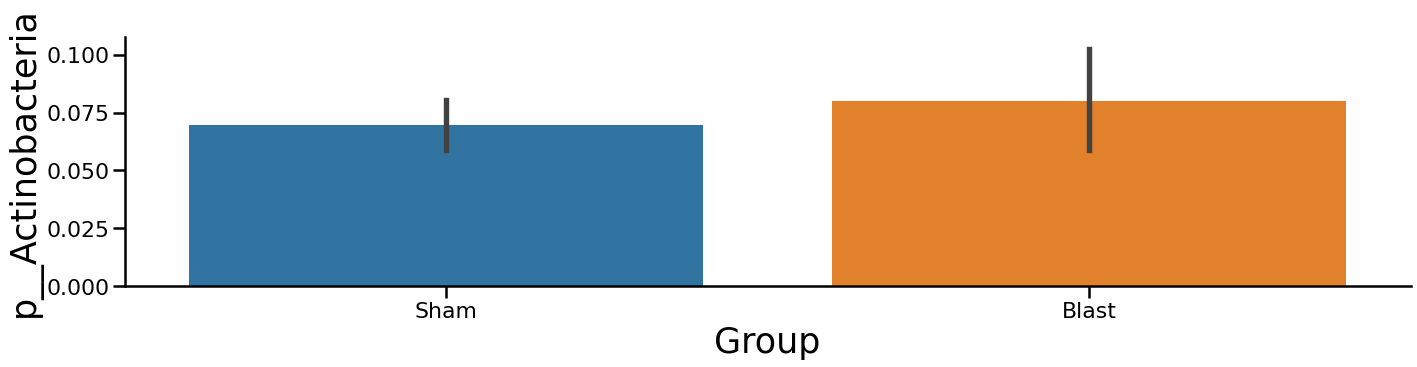





p__Bacteroidetes


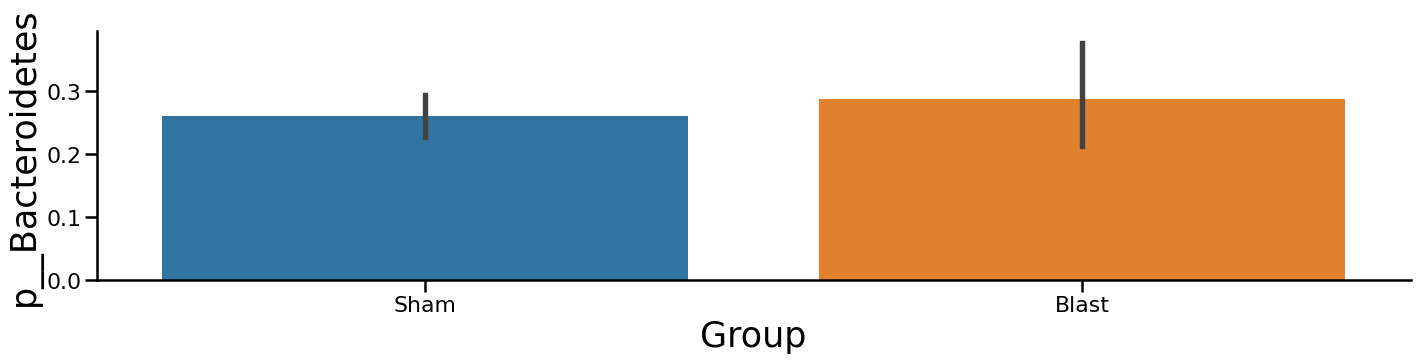





p__Firmicutes


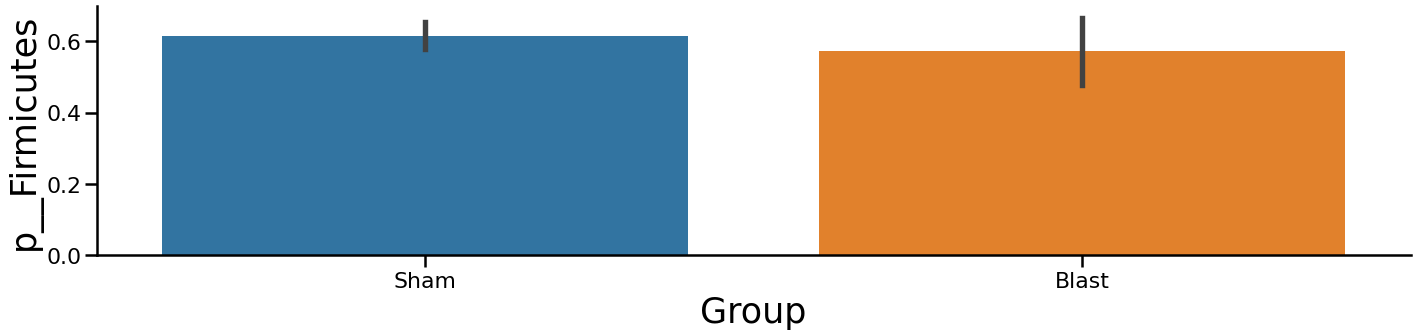





p__Fusobacteria


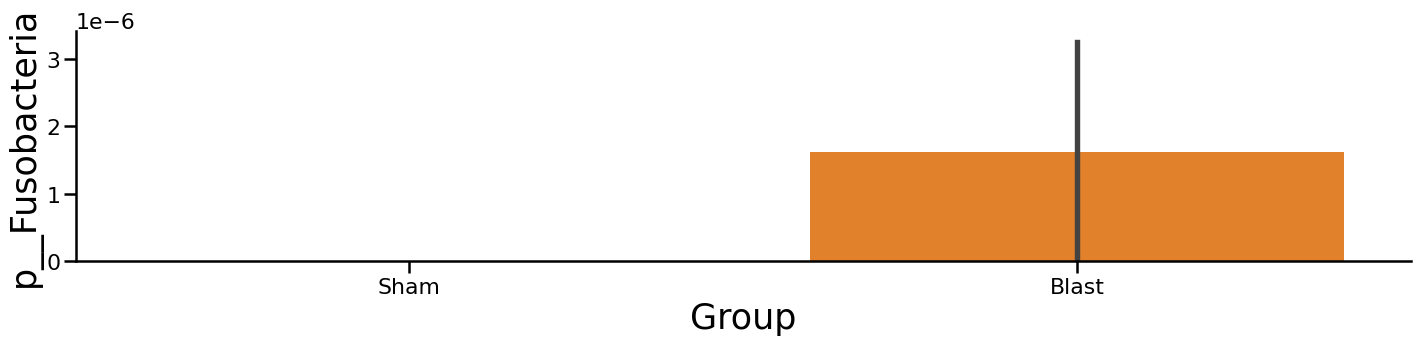





p__Other


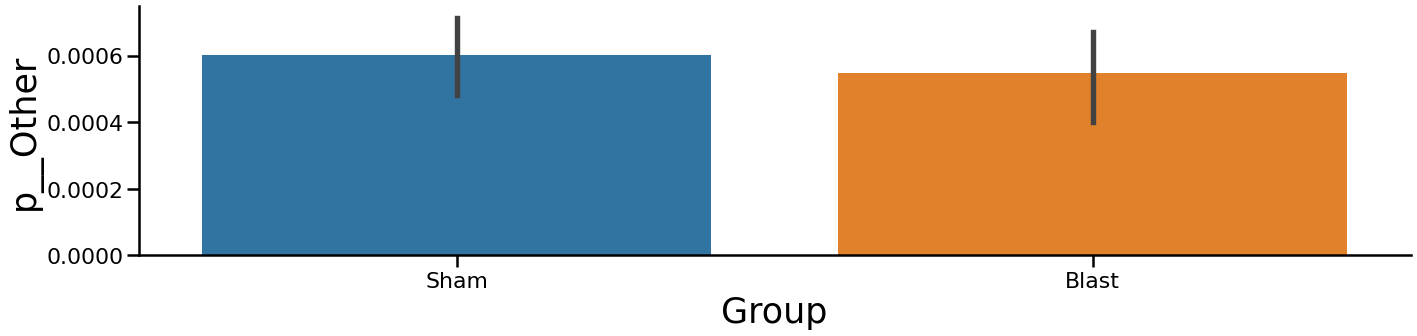





p__Proteobacteria


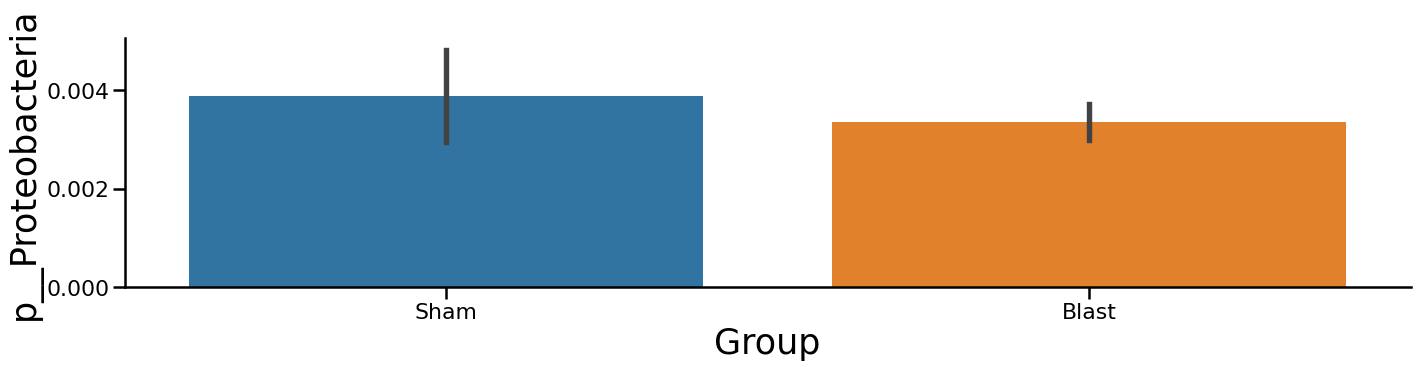





p__Verrucomicrobia


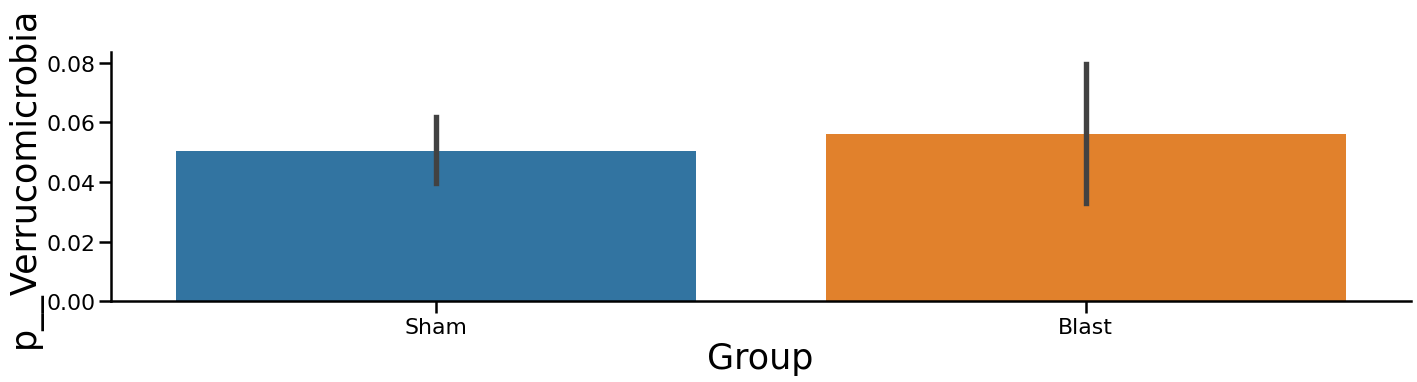





fb_ratio


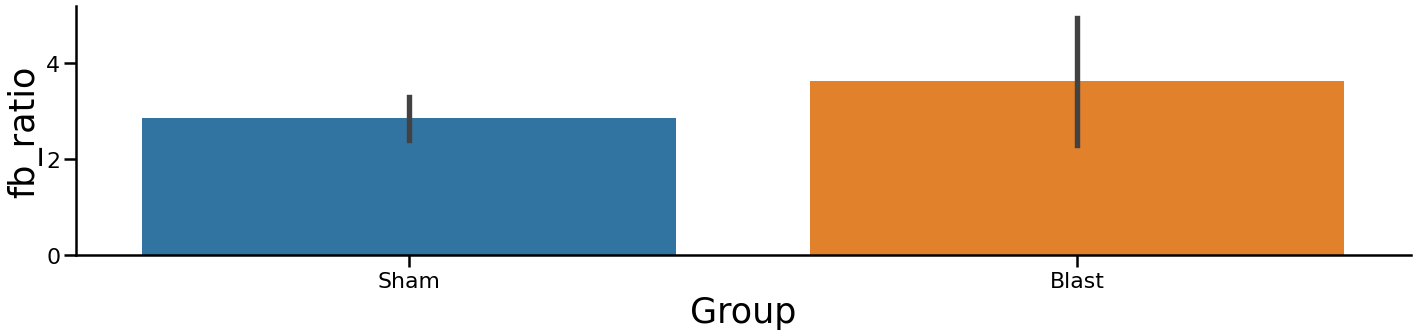





va_sum


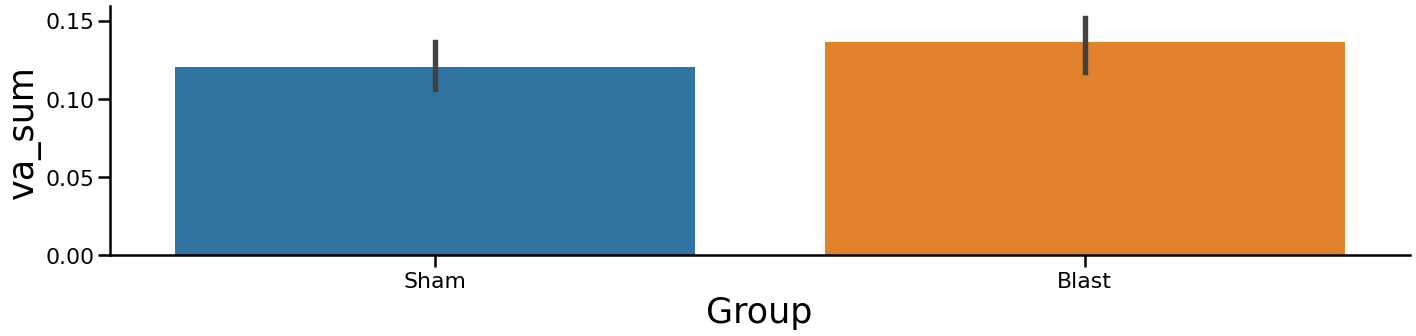

In [38]:
#determine potential significance 
params = ['p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes', 
          'p__Fusobacteria', 'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia', 
          'fb_ratio', 'va_sum']

for param in params:
    try:
        print(param)

        g = sns.catplot(x='Group', y=param, data=data_phylum, kind='bar', height=5, aspect=4, ci=68)
        plt.show()
        print('\n')
        
        #x = OTU_data_diversity[OTU_data_diversity['group'] == 4][param]
        #y = OTU_data_diversity[OTU_data_diversity['group'] == 5][param]
        #z = OTU_data_diversity[OTU_data_diversity['group'] == 7][param]
        #print(stats.kruskal(y, z))
        print('\n')
        
    except:
        pass

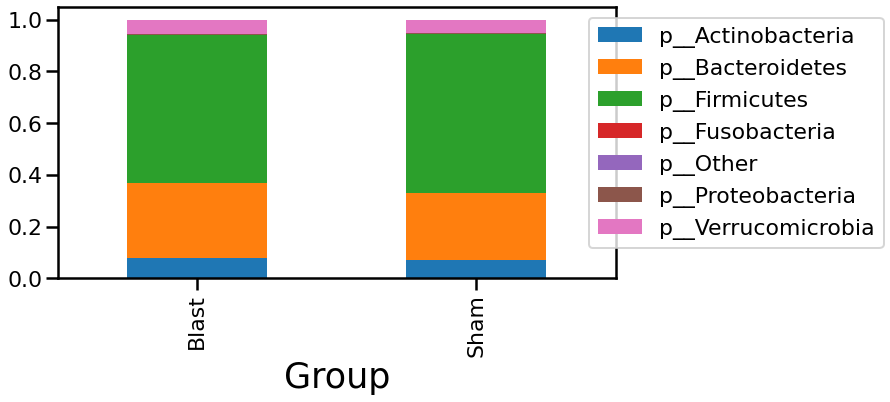

In [41]:
data_phylum[['Group', 'p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes', 
          'p__Fusobacteria', 'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia']].groupby('Group').mean().plot(kind='bar', stacked=True, figsize=(10,5))
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

## Viz correlations

In [43]:
data_phylum['observed'] = data_final_int['observed'].values
data_phylum['chao1'] = data_final_int['chao1'].values
data_phylum['shannon'] = data_final_int['shannon'].values

data_phylum['PC1'] = data_beta_final['PC1'].values
data_phylum['PC2'] = data_beta_final['PC2'].values

print(data_phylum.columns.values)
data_phylum

['Protocol' 'Round_summary' 'Round_main' 'Round_addl' 'file_name'
 'Animal_#' 'animal_code' 'Notes' 'Cage_#' 'Group' 'Sex' 'feces_tp'
 'feces_fs' 'Acute_OFB' 'Sac_TP' 'Treatment' 'PSI_1' 'PSI_2' 'PSI_3'
 'PSI_ave' 'ms_1' 'ms_2' 'ms_3' 'ms_ave' 'imp_1' 'imp_2' 'imp_3' 'imp_ave'
 'LORR_1' 'LORR_2' 'LORR_3' 'LORR_ave' 'wt_1' 'wt_2' 'wt_3' 'wt_24'
 'wt_48' 'wt_72' 'wt_overnight' 'wt_24.1' 'wt_48.1' 'wt_72.1' 'Distance'
 'Mean speed' 'Center : entries' 'Center : time' 'Center : distance'
 'Center : latency' 'p__Actinobacteria' 'p__Bacteroidetes' 'p__Firmicutes'
 'p__Fusobacteria' 'p__Other' 'p__Proteobacteria' 'p__Verrucomicrobia'
 'fb_ratio' 'va_sum' 'observed' 'chao1' 'shannon' 'PC1' 'PC2']


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia,fb_ratio,va_sum,observed,chao1,shannon,PC1,PC2
0,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,145.S,145.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.8,29.8,29.5,29.3,NaN,30.0,0.000000,-1.677852,NaN,0.671141,24.840,0.083,15.0,28.6,3.154,3.4,0.137660,0.211756,0.619606,0.000000,0.000355,0.005923,0.024700,2.926029,0.162361,152.0,201.500000,3.918775,0.148564,-0.054290
1,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,146.S,146.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.6,28.6,28.5,NaN,28.7,-0.694444,-1.041667,NaN,-0.347222,34.051,0.114,14.0,14.2,3.879,26.3,0.026487,0.341850,0.611936,0.000000,0.001303,0.002823,0.015601,1.790073,0.042087,181.0,227.406250,3.820705,-0.092402,-0.142818
2,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,147.S,147.S,NaN,CD40,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2,28.3,28.4,28.5,NaN,28.5,0.354610,1.063830,NaN,1.063830,34.507,0.115,13.0,16.0,4.325,41.4,0.109193,0.373448,0.411462,0.000000,0.000844,0.003550,0.101503,1.101792,0.210696,160.0,205.000000,3.930043,-0.125701,0.015402
6,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,153.S,153.S,single,CD42,Blast,m,112,f,3,NaN,2,19.95,19.03,18.14,19.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.8,28.3,27.8,28.3,NaN,29.7,-8.116883,-8.116883,NaN,-3.571429,26.253,0.088,15.0,25.6,4.259,1.6,0.092892,0.431490,0.394204,0.000008,0.000697,0.002381,0.078327,0.913587,0.171219,150.0,203.714286,3.499581,-0.170477,-0.017116
9,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,158.S,158.S,"head out, arm out",CD44,Blast,m,112,f,3,NaN,2,19.40,19.91,19.00,19.436667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.3,30.3,28.9,29.6,NaN,31.0,-9.009009,-11.111111,NaN,-6.906907,13.586,0.045,6.0,9.3,1.972,113.3,0.133884,0.124113,0.735712,0.000000,0.000319,0.002646,0.003325,5.927755,0.137210,138.0,214.562500,3.590691,0.214510,-0.077515
10,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,159.S,159.S,NaN,CD44,Blast,m,112,f,3,NaN,2,20.15,20.99,20.83,20.656667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.8,33.5,33.1,33.8,NaN,33.7,-6.424581,-5.586592,NaN,-5.865922,21.877,0.073,11.0,15.8,2.876,35.7,0.127572,0.101781,0.763359,0.000000,0.000213,0.003265,0.003810,7.500008,0.131383,116.0,161.000000,3.381762,0.337386,-0.042751
11,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,160.S,160.S,NaN,CD45,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.7,27.7,27.8,27.6,NaN,27.6,0.000000,-0.361011,NaN,-0.361011,14.047,0.047,4.0,5.2,0.669,94.9,0.041605,0.476774,0.387645,0.000000,0.000804,0.008012,0.085161,0.813057,0.126765,148.0,210.666667,3.388742,-0.184601,0.034484
12,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,161.S,161.S,NaN,CD45,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.3,27.2,27.1,26.8,NaN,27.4,-0.366300,-1.831502,NaN,0.366300,23.736,0.079,12.0,19.7,2.861,16.4,0.072946,0.249809,0.645807,0.000000,0.000839,0.006186,0.024412,2.585200,0.097358,169.0,277.500000,3.891364,-0.076977,-0.060645
13,Schindler_male,VNS,VNS_r4,NaN,ship1_VNS4m_24h_72h,162.S,162.S,NaN,CD45,Sham,m,112,f,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,28.9,29.0,28.9,NaN,29.0,-0.344828,-0.344828,NaN,0.000000,24.313,0.081,18.0,27.1,3.431,13.5,0.083983,0.190767,0.706751,0.000000,0.000516,0.006675,0.011309,3.704790,0.095292,

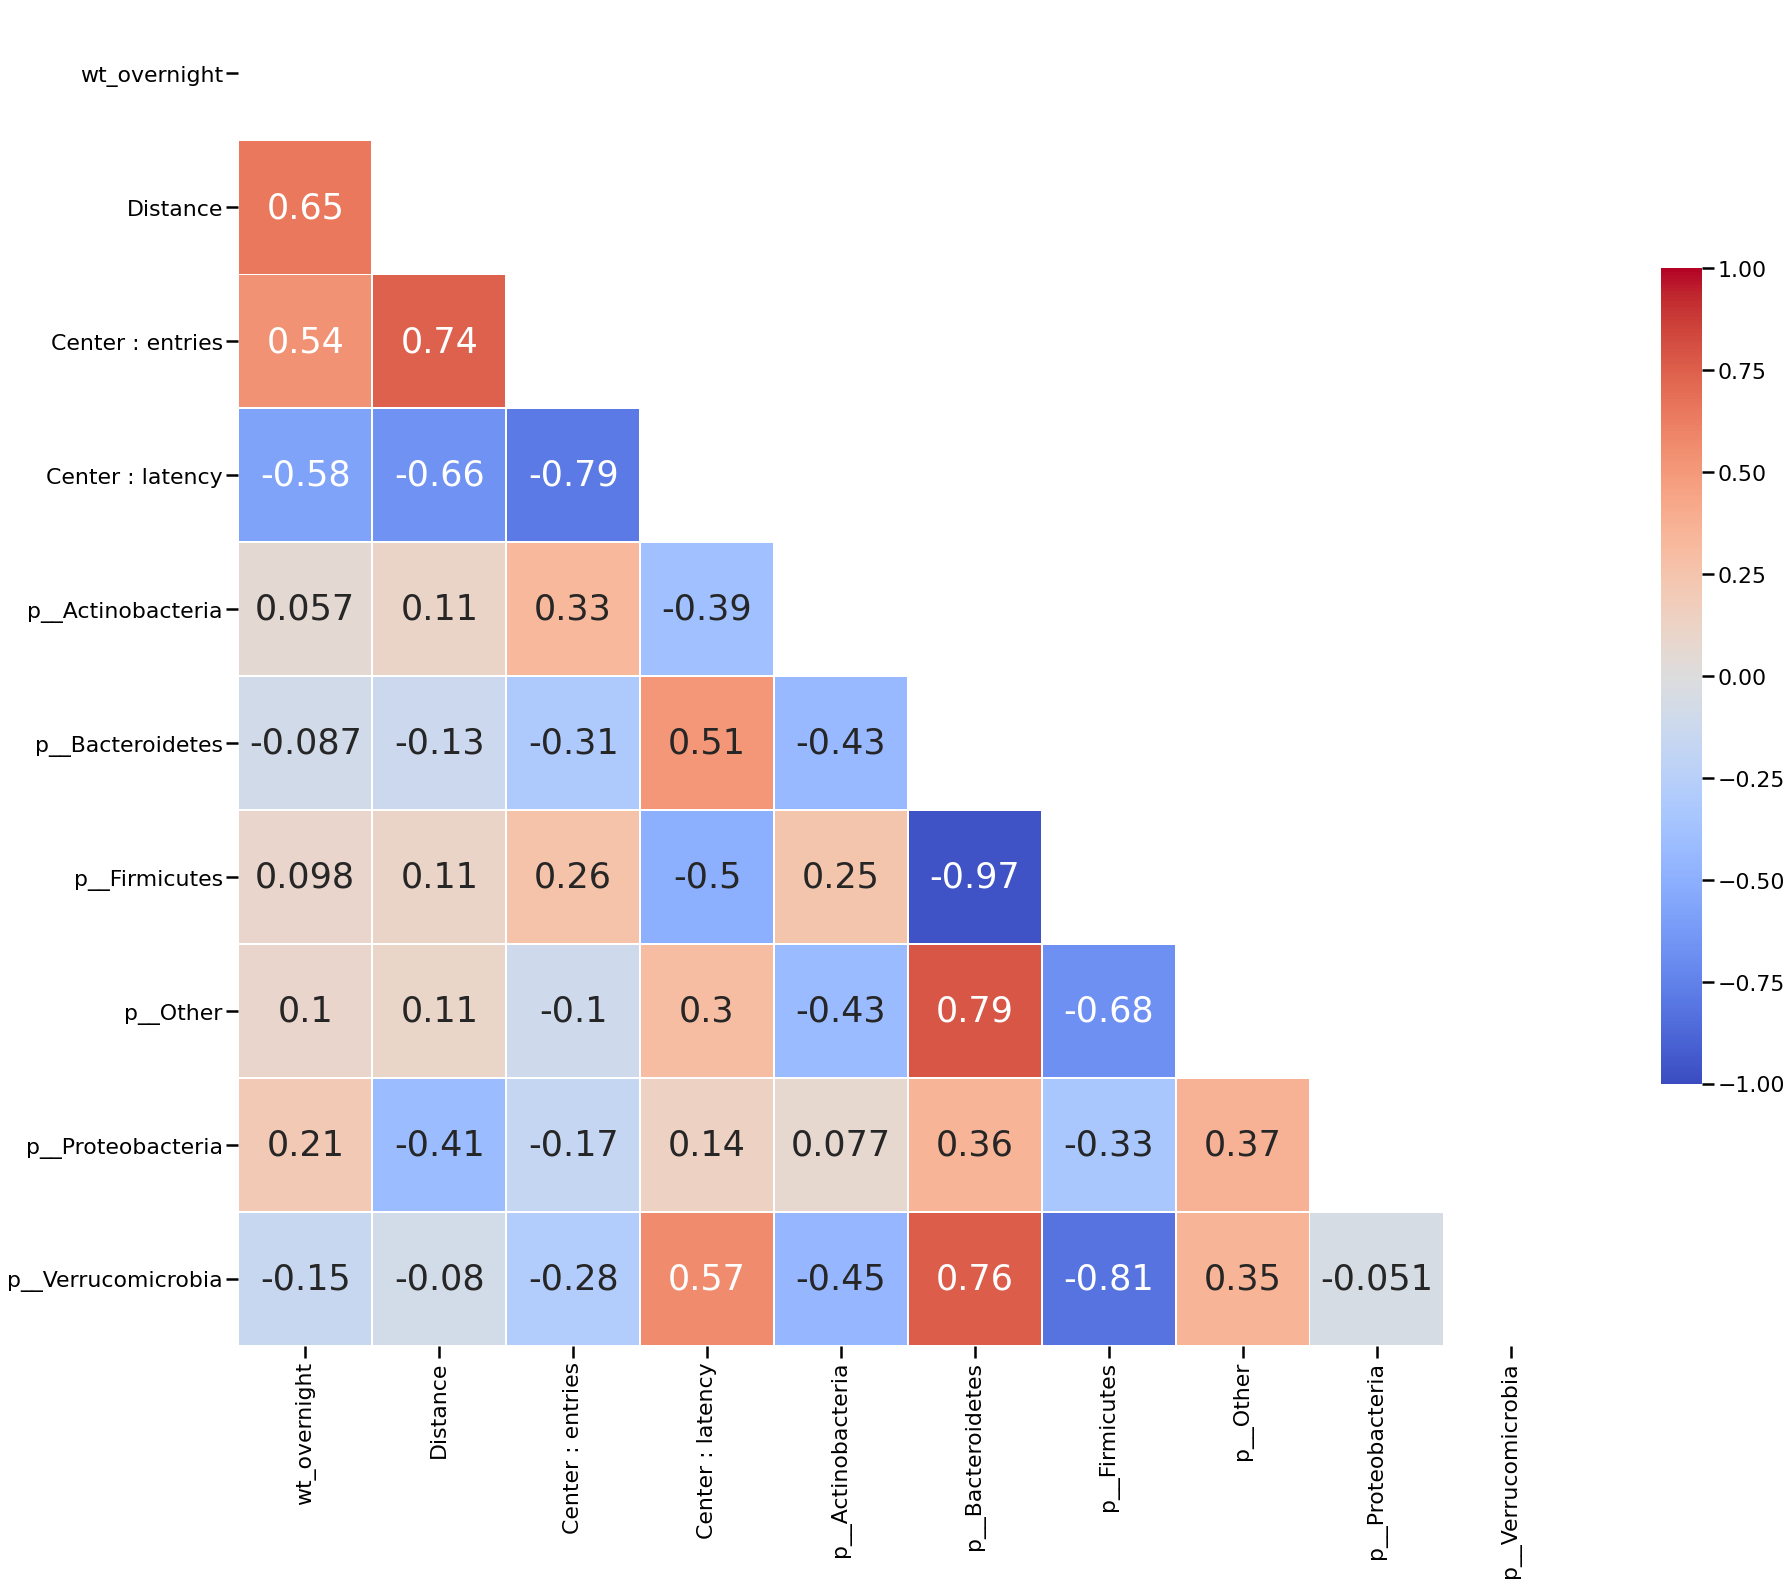

In [50]:
params = ['wt_overnight',
          'Distance', 'Center : entries', 'Center : latency', 
          'p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes',
          'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia', ]

fig, ax = plt.subplots(figsize=(30,30))
corr = data_phylum[params].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0, cmap = 'coolwarm', mask=mask,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

<Figure size 1080x1080 with 0 Axes>

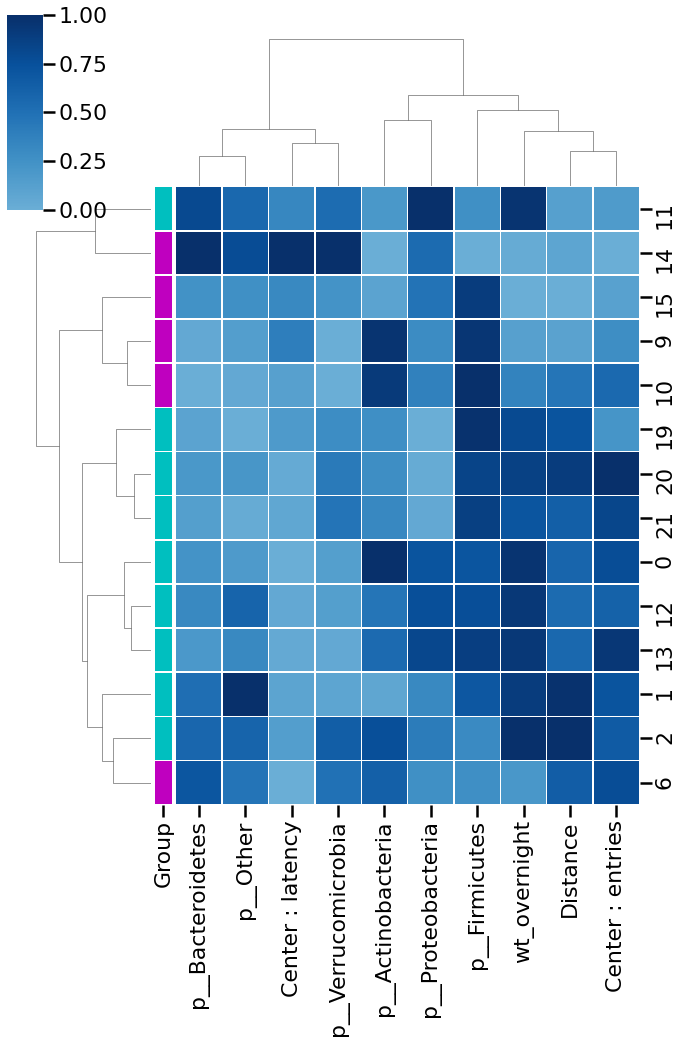

In [49]:
sns.color_palette("flare", as_cmap=True)
params = ['wt_overnight', 
          'Distance', 'Center : entries', 'Center : latency', 
          'p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes',
          'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia']

lut = dict(zip(data_phylum['Group'].unique(), "cmby"))
row_colors = data_phylum['Group'].map(lut)
plt.figure(figsize=(15,15))

g = sns.clustermap(data_phylum[params], row_colors=row_colors,
                 metric="euclidean", standard_scale=1, method="ward",
               vmin=0, vmax=1, center=0, cmap = 'Blues', 
               square=True, linewidths=.5, cbar_kws={"shrink": .5}, figsize=(10,15))
plt.show()